<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M0.532 · Pattern Recognition</p>
<p style="margin: 0; text-align:right;">Computational Engineering and Mathematics Master</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Computers, Multimedia and Telecommunications Department</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

## Image classification with Transfer Learning

In this notebook, we will see how to use a network that has been previously trained on another dataset instead of training it from scratch. Instead of initialize randomly the weights of our network (as done in the previous notebook), we will use the weights from a pretrained network.

Let's start with some imports that we will need in this notebook.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

We also mount our Google Drive on Google Colab in order to use some images that we have stored in a folder.

In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')

Mounted at /content/drive


The data that we will use in this notebook is a dataset named hymenoptera_data, which includes images of ants and bees. Although these categories are not included in the ImageNet dataset, we will use a network that has been previously trained on this large dataset. We will find that the weights of the network optimized for ImageNet dataset will be useful as starting point to update the weights for our specific dataset. 

We define some image transformations for training and validation sets. We will do some augmentation transformations for training (RandomResizedCrop and RandomHorizontalFlip) that are not necessary for validation. Next, we define the dataloaders by using the DataLoader function from torch.utils.data. We get the size of the training and validation sets as well as the names of the categories. Finally, we set our device, which will be cuda if there is any GPU available.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Image Classification/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We define a function to show an image from a Tensor. Notice that when an image is converted to a Tensor, the image is normalized. Therefore, to visualize a Tensor we need to do the inverse procedure of normalization by multiplying the Tensor by the standard deviation (std) and adding the mean.

We use this implemented function to show the images from a batch.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


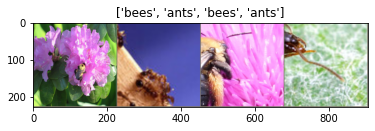

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Next, we define the function to train our model. Notice that one of the arguments of this function is model, which corresponds to a model that has been already trained previously on another dataset. Therefore, the first thing to do is to copy the weights from this pretrained model. Then, the training procedure is the same as we have already seen in the previous notebook where we trained our network from scratch. This function includes both training (where the network parameters are updated) and validation (where the model is not updated, just evaluated).

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We also define a function to visualize some predictions done for a set of images. 

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In the next cell, we will make all the setup for the training. First, we decide which is the pretrained model that we will use as our starting point for training. In this notebook, we will use the model ResNet18, which has been pretrained on ImageNet dataset. Furthermore, we decide that all the weights from this pretrained model will be frozen and not updated during training. The only weights that will change will be the ones from some fully connected layers that we will add on top of the pretrained model. More specifically, what we do in this case is to replace the original fully connected layer with 1000 categories (the number of categories from ImageNet) with a new fully connected layer with as many outputs of the number of categories in our own dataset. 

In [ ]:
model_ft = models.resnet18(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

print(model_ft)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

print(model_ft)

total_params = sum(p.numel() for p in model_ft.parameters())
print('total parameters {}'.format(total_params))
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print('total trainable parameters {}'.format(total_trainable_params))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Once defined the model, with the pretrained model with the new fully connected layer, we can proceed to the training of our model. We will train our model for 25 epochs.

In [ ]:
model_conv = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6011 Acc: 0.6762
val Loss: 0.3092 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5290 Acc: 0.7623
val Loss: 0.1774 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4522 Acc: 0.7746
val Loss: 0.1791 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5335 Acc: 0.7869
val Loss: 0.1711 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3963 Acc: 0.8402
val Loss: 0.2234 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5245 Acc: 0.7746
val Loss: 0.1644 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4051 Acc: 0.8484
val Loss: 0.1806 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3521 Acc: 0.8361
val Loss: 0.1704 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3767 Acc: 0.8197
val Loss: 0.1808 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4133 Acc: 0.8156
val Loss: 0.1864 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3337 Acc: 0.8689
val Loss: 0.1892 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3636 Acc: 0.8443
val Loss: 0.2189 Acc: 0.9477

Epoch 12/24
----------
t

Finally, once the model has been trained, we visualize the predictions done for a set of test examples.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


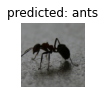

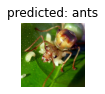

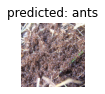

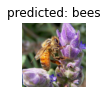

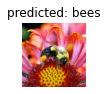

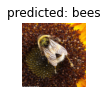

In [ ]:
visualize_model(model_conv)